# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [1]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm

#Para el ejercicio 2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_curve

import sklearn.model_selection
from scipy.stats import randint as sp_randint

# Ejercicio Opcional
from arbolDeDecision import MiClasificadorArbol

In [2]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 
    
X_competencia = pd.read_csv("X_competencia1.csv", index_col="index")
y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")
display(X)
display(y)

#pd.plotting.scatter_matrix(X, c=y, s=80, figsize=(15, 8), marker='o', alpha=.8);

# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.2516,0.9375,-1.1980,0.4577,0.9287,0.5373,0.2476,...,0.5829,-0.5494,0.4607,1.2182,0.1025,3.0034,-0.0344
496,0.6246,-1.0590,0.9491,0.2687,0.6610,-1.6657,0.3982,...,-0.1075,0.8993,-0.4229,0.3977,-0.0808,-1.7054,-0.4786
497,0.2677,0.1802,0.7154,0.3542,-0.9023,-1.7792,-0.0121,...,0.8491,0.7469,0.2071,-1.0090,0.3317,-1.7513,-0.5397


,output
index,
0,0
1,0
2,0
3,0
4,1
...,...
495,1
496,0
497,1


## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. 

(49, 200)
(451, 200)


,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
12,-1.5391,2.7920,1.2237,0.0690,0.6025,-0.7872,1.9328,...,-0.4485,-1.4975,1.0337,-0.4614,0.7221,0.1945,1.1358
18,0.2914,1.4977,0.5042,-1.1535,0.1608,2.2100,-0.4855,...,0.4091,1.5813,-0.1546,-1.0093,-0.2091,0.6965,1.6663
19,-0.7882,-0.7022,2.4834,-1.9349,1.3327,-0.8933,0.1448,...,-1.2189,0.1303,2.9109,0.4565,2.0403,0.0804,0.8195
27,0.0410,-0.5786,0.7457,-1.0642,-0.0713,0.0480,0.7058,...,-0.8771,-1.5508,0.4705,-0.1252,-1.1654,-0.0512,0.4096
61,0.6618,0.7850,1.8285,-0.6554,1.2799,0.1840,-1.6153,...,-2.7597,0.9145,1.7056,0.7891,0.3824,-0.0719,-2.8690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,-1.5736,-0.6486,-1.1086,-1.1645,-2.2992,-0.2651,-0.1717,...,-1.2335,-0.0688,-0.7236,-2.1597,-0.2370,-0.4630,0.2360
465,1.0896,-0.6290,-1.1061,-0.2319,-0.6213,0.9187,-0.4865,...,0.9129,0.0781,-1.5507,-0.0066,0.2451,-0.0201,-0.0667
470,1.1918,0.0183,-1.3718,0.1060,-2.1624,-0.0124,0.9452,...,-1.2137,0.1246,-1.2312,0.2253,1.3253,0.0705,-0.3917
486,0.2951,1.4307,-0.8935,-3.7474,-0.6663,-0.8604,0.4749,...,1.4374,0.1864,-0.0525,0.0123,0.5163,-0.7259,0.7693


,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.2516,0.9375,-1.1980,0.4577,0.9287,0.5373,0.2476,...,0.5829,-0.5494,0.4607,1.2182,0.1025,3.0034,-0.0344
496,0.6246,-1.0590,0.9491,0.2687,0.6610,-1.6657,0.3982,...,-0.1075,0.8993,-0.4229,0.3977,-0.0808,-1.7054,-0.4786
497,0.2677,0.1802,0.7154,0.3542,-0.9023,-1.7792,-0.0121,...,0.8491,0.7469,0.2071,-1.0090,0.3317,-1.7513,-0.5397
498,0.1926,0.7834,1.7056,0.3418,-0.8350,0.4068,0.0495,...,-0.0130,0.1483,0.5019,-0.0020,-1.6642,2.5117,-0.0118


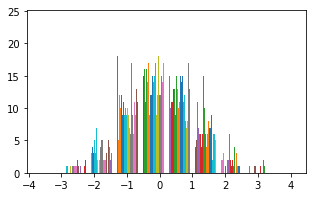

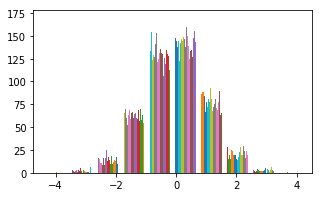

In [3]:
# EJERCICIO 1. 
import random
np.random.seed(1234)

Xdev  = []
Ydev  = []
Xeval = []
Yeval = []
iPos  = []
iNeg  = []

for i in range(X.shape[0]):
    if y.loc[i].iloc[0] == 1:
        iPos.append(i)
    else: 
        iNeg.append(i)
        

random_Positives =random.sample(range(1, len(iPos)), int(len(iPos)/10))
random_Negatives =random.sample(range(1, len(iNeg)), int(len(iNeg)/10))
random_values= []

for e in random_Positives:
    random_values.append(iPos[e])
for e in random_Negatives:
    random_values.append(iNeg[e])  
    
for i in range(X.shape[0]):
    if i in random_values:
        Xeval.append(X.loc[i])
        Yeval.append(y.loc[i])
    else:
        Xdev.append(X.loc[i])
        Ydev.append(y.loc[i])

X_dev, X_eval, y_dev, y_eval = pd.DataFrame(Xdev),pd.DataFrame(Xeval),pd.DataFrame(Ydev),pd.DataFrame(Yeval)
        
print(str(X_eval.shape))
print(str(X_dev.shape))

display(X_eval)
display(X_dev)

#Distribucion de los X de evaluacion
plt.figure(figsize=(5, 3))
plt.hist(np.array(X_eval))
plt.show()

#Distribucion de los X de entrenamiento
plt.figure(figsize=(5, 3))
plt.hist(np.array(X_dev))
plt.show()

## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   **

----

In [4]:
### Arbol de sklearn ###
arbol = DecisionTreeClassifier(max_depth=3)

#######################
### Ejercicio Extra ###
#######################

# Descomentar para usar este arbol 
#arbol = MiClasificadorArbol(max_depth=3)

In [5]:
accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

X_eval_np = np.array(X_eval)
y_eval_np = np.array(y_eval).ravel()

display(len(X_dev_np))
display(y_dev_np)
arbol.fit(X_dev_np, y_dev_np)

def get_accuracy(y_pred, y_eval_np):
    return np.mean(y_pred == y_eval_np)
    
def show_prediction_accuracy(y_pred, y_eval_np, x_eval_np):
    print("Predicciones sobre el test set:\n {}".format(y_pred))
    print("Score sobre el test set: {:.2f}".format(np.mean(y_pred == y_eval_np))) # A mano
    print("Score sobre el test set: {:.2f}".format(arbol.score(x_eval_np, y_eval_np))) # usando el método score.

#Generamos los 5 folds
kf = KFold(n_splits=5)

accuracy_train      = []
accuracy_validation = []
roc_train      = []
roc_validation = []

for train_index, test_index in kf.split(X_dev_np):
    #print("TRAIN:", train_index, "TEST:", test_index)
    kf_X_train, kf_X_test = X_dev_np[train_index], X_dev_np[test_index]
    kf_y_train, kf_y_test = y_dev_np[train_index], y_dev_np[test_index]
    
    #Entrenamos el arbol con el fold actual
    arbol.fit(kf_X_train, kf_y_train)
    
    #Testeamos contra el fold de test
    kf_y_pred     = arbol.predict(kf_X_test)
    kf_y_pred_dev = arbol.predict(kf_X_train)
        
    #Calculamos accuracy
    accuracy_validation.append(get_accuracy(kf_y_pred, kf_y_test) )
    accuracy_train.append(get_accuracy(kf_y_pred_dev, kf_y_train) )
    
    #Calculamos roc score
    roc_train.append(sklearn.metrics.roc_auc_score(kf_y_train, kf_y_pred_dev))
    roc_validation.append(sklearn.metrics.roc_auc_score(kf_y_test, kf_y_pred))
    
df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"]   = accuracy_train     # cambiar por accuracies_training
df["Accuracy (validación)"] = accuracy_validation  # cambiar por accuracies_validation
df["AUC ROC (training)"]    = roc_train      # cambiar por aucs_training
df["AUC ROC (validación)"]  = roc_validation    # cambiar por aucs_validation

display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
# df.plot(kind="bar")
# plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
# plt.show()

451

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.7861,0.6813,0.7629,0.6790
2,0.8061,0.6889,0.8092,0.6989
3,0.8144,0.6222,0.8052,0.6025
4,0.8366,0.6444,0.8371,0.6456
5,0.8255,0.5889,0.8278,0.5905


In [6]:
resultados_training   = []
resultados_validation = []

########################################################

np.random.seed(SEED)
for criterio in ["gini", "entropy"]:
     for altura in [3, 5, None]:
        
        arbol = DecisionTreeClassifier(max_depth=altura, criterion=criterio)
        arbol.fit(X_dev_np, y_dev_np)
        
        #Entrenamiento
        y_pred = arbol.predict(X_dev_np) 
        resultados_training.append( get_accuracy(y_pred, y_dev_np) )
        
        #Validacion
        y_pred = arbol.predict(X_eval_np)
        resultados_validation.append( get_accuracy(y_pred, y_eval_np) )

#########################################################

df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"]   = resultados_training# reemplazar por resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation # reemplazar por resultados_validation

   
display(HTML("<h3> TABLA 2 </h3>"))
display(df)

,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.7982,0.6939
1,5,Gini,0.9313,0.6735
2,Inifinito,Gini,1.0000,0.6122
3,3,Ganancia de Información,0.7761,0.5714
4,5,Ganancia de Información,0.8825,0.6122
5,Inifinito,Ganancia de Información,1.0000,0.6122


### Ejercicio Extra
Para esto tomamos como base el arbol del notebook 4 y lo importamos a un archivo .py para usarlo. 

**Para probarlo, simplemente descomentar la linea del principio de este ejercicio donde se crea el arbol de decision**.

Cambios:
    - En las preguntas comparar por >= para tomar espacios continuos.
    - Agregamos la entropia como calculo de ganancia
    - Agregamos los parametros de profundidad maxima y seleccion de criterio para el arbol. 
    

## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [7]:
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

##############################################
################# Auxiliares #################
##############################################

def top_resultados(grid, top=5):
    ## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
    print("Top {} combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))

def bot_resultados(grid, bot=5):
    print("Bot {} combinaciones".format(bot))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=True).head(bot))
    
def correr_y_mostrar(estimator, parameters, folds, top):
    grid = GridSearchCV(estimator, parameters, cv=folds, scoring='roc_auc')
    time_before = time.time()
    grid.fit(X_dev_np, y_dev_np)
    time_after = time.time()
    top_resultados(grid, top)
    bot_resultados(grid, top)
    return (time_after - time_before) * 1000.0

# Para usar en caso de tener probabilidades a priori
priors = [(0.1,0.9),(0.2,0.8),(0.3,0.7),(0.4,0.6),(0.5,0.5),(0.6,0.4),(0.7,0.3),(0.8,0.2),(0.9,0.1)]

### Decision Trees

Para este algoritmo decidimos usar solo los atributos criterio y max_depth, ya que son los mas simples a la hora de explicar como se comportan y como afectas a los datos de entrenamiento.

Sin embargo, al hacer algunas pruebas nos encontramos con otro parametro que nos parecio interesante, a continuacion hacemos los analisis en los dos casos (solo con criterio y max_depth | agregando el nuevo parametro).

In [8]:
parametersDecisionTree = {
    'criterion':['entropy','gini'],
    'max_depth':range(1,51)
}

tiempoDecisionTree = correr_y_mostrar(
    DecisionTreeClassifier(),
    parametersDecisionTree,
    5,
    5
)

parametersDecisionTree2 = {
    'criterion':['entropy','gini'],
    'max_depth':range(1,51),
    'min_samples_split':range(2, 30)
}

tiempoDecisionTree2 = correr_y_mostrar(
    DecisionTreeClassifier(),
    parametersDecisionTree2,
    5,
    5
)

Top 5 combinaciones


,criterion,max_depth,mean_score_validation,mean_score_training
3,entropy,4,0.7367,0.9254
2,entropy,3,0.7328,0.8673
4,entropy,5,0.7204,0.9639
1,entropy,2,0.7194,0.7964
51,gini,2,0.7123,0.8084


Bot 5 combinaciones


,criterion,max_depth,mean_score_validation,mean_score_training
55,gini,6,0.5874,0.9913
54,gini,5,0.6135,0.9730
88,gini,39,0.6166,1.0000
93,gini,44,0.6171,1.0000
77,gini,28,0.6174,1.0000


KeyboardInterrupt: 

### Solo con dos parametros

A priori se puede ver que los mejores vs peores resultados tienen profundidades maximas bastante distintas(A excepcion del peor elemento con altura 6, suponemos que fue una muy mala muestra que justo dio ese resultado). Entre los mejores arboles en promedio no superan los 5 niveles, mientras que en los peores suele estar alrededor del 14/15.

Una cosa importante a remarcar es que en los peores arboles, el score del set de entrenamiento es bastante alto (y 1 en varios casos), mientras que en los mejores este baja un poco. Esto se da por la tendencia a overfittear  data rapidamente de estos arboles a medida que aparecen mas niveles (Las hipotesis que toma se vuelven casos mas particulares).

Por como se dan los resultados pareciera que la entropia funciona un poco mejor que gini como criterio, pero suponemos que esto no necesariamente es asi en el caso general. 

### Agregando min_samples_split

Podemos ver que con min_samples_split el arbol se limita a cortar un nodo si hay al menos esa cantidad de samples que caen en el. 

Teniendo lo anterior en cuenta podemos observar que los arboles que dieron los mejores resultados fueron los que tuvieron mayor profundidad y mayor cantidad de samples como minimo para separar un nodo. Nuestra suposicion es que al ser relativamente alta la cantidad minima de splitteo, esto evita overfittear sobre casos no muy normales en los datos y obtener profundidad sobre informacion que es relevante. Pero manteniendo un limite a la hora de crear hipotesis demasiado particulares.

### Naive Bayes

En este estimador solo tomamos las probabilidades a priori de las clases.

In [9]:
parametersNaiveBayes = {
    'priors':priors
}

tiempoBayes = correr_y_mostrar(
    GaussianNB(), 
    parametersNaiveBayes, 
    5, 
    5
)

Top 5 combinaciones


,priors,mean_score_validation,mean_score_training
0,"(0.1, 0.9)",0.8308,0.8649
8,"(0.9, 0.1)",0.8307,0.8654
1,"(0.2, 0.8)",0.8306,0.8649
2,"(0.3, 0.7)",0.8306,0.8650
3,"(0.4, 0.6)",0.8306,0.8649


Bot 5 combinaciones


,priors,mean_score_validation,mean_score_training
7,"(0.8, 0.2)",0.8303,0.8653
6,"(0.7, 0.3)",0.8304,0.8653
5,"(0.6, 0.4)",0.8305,0.8653
1,"(0.2, 0.8)",0.8306,0.8649
2,"(0.3, 0.7)",0.8306,0.8650


A simple vista se puede observar que no hay mucha diferencia en los scores tanto de validacion como train y tambien entre los mejores y peores. Esto llama la atencion ya que la intuicion diria que la probabilidad a priori de las clases deberia influir en el modelo.

### KNN

In [ ]:
parametersKNN1 = {
    'n_neighbors' : list(range(1, 3)),
    'weights'     : ['uniform', 'distance'],
    'leaf_size'   : list(range(30,31)),
    'p'           : [1, 2, 3, 4]
}

parametersKNN = {
    'n_neighbors' : list(range(4, 6)),
    'weights'     : ['uniform', 'distance']
}

tiempoKNN = correr_y_mostrar(
    KNeighborsClassifier(), 
    parametersKNN, 
    5, 
    5
)
#tiempoKNN_random = correr_randomized_y_mostrar(estimator, parameters, 5, 5)

### SVM

In [ ]:
parametersSVM = {
    'C':[1e-15, 1e-5, 1e-2, 1.0, 200.0, 500.0, 100000.0],
}

timepoSVM = correr_y_mostrar(
    LinearSVC(), 
    parametersSVM, 
    5,
    5
)

Para este algoritmo decidimos usar el parametro C. Este controla el nivel de tolerancia al clasificar erroneamente las muestras, con lo que un C chico generaria un hiperplano con margen mas grande, permitiendo asi una hipotesis mas simple(TODO: chequear esto). Por otro lado tomando un C grande, se achica el margen del hiperplano y forzando a clasificar mejor los datos de entrenamiento.

En los resultados se puede ver que con valores grandes de C la muestra tiende a "overfittearse", mientras que con valores mas chicos el score de validacion es mas alto.

### LDA

### Experimento 1

Para el primero probamos usar los parametros **svd**, **n_components** y **priori**. 

In [27]:
parametersLDA_svd = {
    'solver'            :['svd'],
    'priors'            :priors,
    'n_components'      :[0, 1, 2, 3, 4, 5, 6],
}

tiempoLDA_svd = correr_y_mostrar(
    LDA(),
    parametersLDA_svd,
    5,
    5
)

Top 5 combinaciones


,n_components,priors,solver,mean_score_validation,mean_score_training
0,0,"(0.1, 0.9)",svd,0.702,0.9931
47,5,"(0.3, 0.7)",svd,0.702,0.9931
34,3,"(0.8, 0.2)",svd,0.702,0.9931
35,3,"(0.9, 0.1)",svd,0.702,0.9931
36,4,"(0.1, 0.9)",svd,0.702,0.9931


Bot 5 combinaciones


,n_components,priors,solver,mean_score_validation,mean_score_training
0,0,"(0.1, 0.9)",svd,0.702,0.9931
33,3,"(0.7, 0.3)",svd,0.702,0.9931
34,3,"(0.8, 0.2)",svd,0.702,0.9931
35,3,"(0.9, 0.1)",svd,0.702,0.9931
36,4,"(0.1, 0.9)",svd,0.702,0.9931


Nos llama la atencion que todos los scores den iguales variando los parametros(Algo parecido a lo que nos paso en **Naive Bayes**), lo que nos da dos suposiciones: 
- Por como funcione svd, el data set se comporta siempre igual
- Hay algun tema con la tecnica que hace que de siempre lo mismo.

Fuera de esto, podemos ver que el score de training y validacion difieren bastante. A continuacion, vamos a probar con otros solvers para comparar.

### Experimento 2

En este experimento vamos a usar los solvers **lsqr**(cuadrados minimos) y **eigen**, junto con **priors** y **shrinkage** para 

In [36]:
a = np.linspace(0.1,0.9,10)
b = a.tolist()
b.append('auto')
display(b)

[0.1,
 0.18888888888888888,
 0.2777777777777778,
 0.3666666666666667,
 0.4555555555555556,
 0.5444444444444445,
 0.6333333333333333,
 0.7222222222222222,
 0.8111111111111111,
 0.9,
 'asdas']

In [39]:
# probamos con n_components para reduccion pero no afecto
shrinkage = np.linspace(0.1,1.0).tolist()
shrinkage.append('auto')

parametersLDA = {
    "solver": ["lsqr", "eigen"],
    "priors": priors,
    "shrinkage": shrinkage
}

tiempoLDA = correr_y_mostrar(
    LDA(),
    parametersLDA,
    5,
    10
)

Top 10 combinaciones


,priors,shrinkage,solver,mean_score_validation,mean_score_training
582,"(0.6, 0.4)",0.7612,lsqr,0.8513,0.9360
479,"(0.5, 0.5)",0.7429,eigen,0.8512,0.9410
879,"(0.9, 0.1)",0.6694,eigen,0.8512,0.9349
877,"(0.9, 0.1)",0.651,eigen,0.8511,0.9373
779,"(0.8, 0.2)",0.6878,eigen,0.8509,0.9398
574,"(0.6, 0.4)",0.6878,lsqr,0.8509,0.9493
483,"(0.5, 0.5)",0.7796,eigen,0.8509,0.9330
576,"(0.6, 0.4)",0.7061,lsqr,0.8509,0.9465
875,"(0.9, 0.1)",0.6327,eigen,0.8509,0.9396
478,"(0.5, 0.5)",0.7429,lsqr,0.8508,0.9405


Bot 10 combinaciones


,priors,shrinkage,solver,mean_score_validation,mean_score_training
0,"(0.1, 0.9)",0.1,lsqr,0.7502,0.9781
1,"(0.1, 0.9)",0.1,eigen,0.7539,0.9781
2,"(0.1, 0.9)",0.1184,lsqr,0.7574,0.9783
102,"(0.2, 0.8)",0.1,lsqr,0.7591,0.9875
103,"(0.2, 0.8)",0.1,eigen,0.7617,0.9873
3,"(0.1, 0.9)",0.1184,eigen,0.7622,0.9777
4,"(0.1, 0.9)",0.1367,lsqr,0.7633,0.9784
204,"(0.3, 0.7)",0.1,lsqr,0.7653,0.9908
104,"(0.2, 0.8)",0.1184,lsqr,0.7665,0.9871
105,"(0.2, 0.8)",0.1184,eigen,0.7677,0.9866


A simple vista se puede notar la diferencia con **svd**, el peor score aqui es mejor que el mejor de **svd**. 

Por otro lado no parece influir mucho la tecnica que se use, ambos solvers parecen dar buenos resultados mientras que probabilidades a priori mas cercanas al **(0.5, 0.5)** quedan como mejor rankeadas.

Algo importante a resaltar es **shrinkage**, valores mas cercanos al 1 dan muy buenos resultados. Reducen un poco el score en el set de entrenamiento pero el de validacion aumenta casi en un 0.1 comparado con los peores casos. Esto sugiere que el valor optimo esta aproximadamente en 0.75.

## Ejercicio Extra

**Obs:** 
- RandomizeSearchCV cuenta con el parametro **n_iter** para regular la cantidad de parametros que busca, esto lo vamos a usar a lo largo de los experimentos.

In [ ]:
#Auxiliares para correr randomized search
def correr_randomized_y_mostrar(estimator, parameters, folds, top,  iteraciones=None):
    if(iteraciones is None):
        grid = RandomizedSearchCV(estimator, parameters, cv=folds, scoring='roc_auc')
    else:
        grid = RandomizedSearchCV(estimator, parameters, cv=folds, scoring='roc_auc', n_iter=iteraciones)
        
    time_before = time.time()
    grid.fit(X_dev_np, y_dev_np)
    time_after = time.time()
    top_resultados(grid, top)
    bot_resultados(grid, top)
    return (time_after - time_before) * 1000.0

def verTiempo(original, random):
    display("original: {:f}".format(original))
    display("random: {:f}".format(random))
    display("diferencia: {:f}".format( np.absolute(original-random) ))

### Decision Trees

Para este experimento tomamos el arbol de decision con solo 2 parametros que discutimos en la primera parte del ejercicio.

In [ ]:
parametersDecisionTree = {
    'criterion':['entropy','gini'],
    'max_depth':range(1,51)
}

tiempoRandomDecisionTree = correr_randomized_y_mostrar(
    DecisionTreeClassifier(),
    parametersDecisionTree,
    5,
    5,
    100
)

verTiempo(tiempoDecisionTree, tiempoRandomDecisionTree)

Al ser un espacio de busqueda discreto, grid y random search ven los mismos  elementos, dando asi los mismos resultados. Podemos ver que randomSearch tarda un poco menos en correr, pero no es significativo.

### Naive Bayes

In [ ]:
parametersNaiveBayes = {
    'priors':priors
}

#tiempoRandomBayes = correr_randomized_y_mostrar(
#    GaussianNB(), 
#    parametersNaiveBayes, 
#    5, 
#    5
#)

### KNN

### SVM

### LDA

In [ ]:
#####################################################################
######################### Comparacion de Tiempos ####################
#####################################################################
#tiempoDecisionTree
#tiempoBayes
#tiempoKNN
#tiempoLDA
#timepoSVM

## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.
